In [1]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import scanpy as sc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples"

In [3]:
metacell_adata = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/seacells_F_FastIIB_FastIIX_harmonyv2.h5ad'
adata = sc.read_h5ad(metacell_adata)

In [4]:
adata

AnnData object with n_obs × n_vars = 451 × 3000
    obs: 'y', 'sample_id'

#### Sparsity based gene filtering

In [5]:
import numpy as np
from scipy.sparse import issparse

def calculate_zero_proportion(adata, axis='genes'):
    """
    Calculate the proportion of zeros for either genes (features) or cells in an AnnData object.
    
    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing gene expression data
    axis : str, default 'genes'
        Which axis to calculate zeros for:
        - 'genes' or 'features' or 'columns': calculate zeros per gene (column-wise)
        - 'cells' or 'rows': calculate zeros per cell (row-wise)
        
    Returns:
    --------
    proportion_zeros : numpy.ndarray
        Array containing the proportion of zeros for each gene or cell
    """
    if axis.lower() in ['genes', 'features', 'columns']:
        # Calculate zeros per gene (column-wise)
        if issparse(adata.X):
            # For sparse matrix: count non-zeros, then calculate zeros
            n_cells = adata.n_obs
            non_zero_per_gene = np.array((adata.X != 0).sum(axis=0)).flatten()
            zero_per_gene = n_cells - non_zero_per_gene
            proportion_zeros = zero_per_gene / n_cells
        else:
            # For dense matrix
            proportion_zeros = (adata.X == 0).sum(axis=0) / adata.n_obs
            
    elif axis.lower() in ['cells', 'rows']:
        # Calculate zeros per cell (row-wise)
        if issparse(adata.X):
            # For sparse matrix: count non-zeros, then calculate zeros
            n_genes = adata.n_vars
            non_zero_per_cell = np.array((adata.X != 0).sum(axis=1)).flatten()
            zero_per_cell = n_genes - non_zero_per_cell
            proportion_zeros = zero_per_cell / n_genes
        else:
            # For dense matrix
            proportion_zeros = (adata.X == 0).sum(axis=1) / adata.n_vars
    else:
        raise ValueError("axis must be 'genes', 'features', 'columns', 'cells', or 'rows'")
    
    return proportion_zeros

def plot_sparsity_analysis(proportion_zeros, str='features', figsize=(14, 5), bins=50, 
                                color='steelblue', alpha=0.7, show_stats=True):
    """
    Plot cell/feature sparsity analysis with histogram and cumulative distribution.
    
    Parameters:
    -----------
    proportion_zeros : numpy.ndarray
        Array containing the proportion of zeros for each feature/cell
    figsize : tuple, default (14, 5)
        Figure size for the plots
    bins : int, default 50
        Number of bins for the histogram
    color : str, default 'steelblue'
        Color for the histogram bars
    alpha : float, default 0.7
        Transparency for the histogram bars
    show_stats : bool, default True
        Whether to print summary statistics
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    axes : numpy.ndarray
        Array of axes objects
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot 1: Histogram of cell/feature sparsity
    axes[0].hist(proportion_zeros, bins=bins, edgecolor='black', alpha=alpha, color=color)
    axes[0].set_xlabel('Proportion of zeros')
    axes[0].set_ylabel('Number of ' + str)
    axes[0].set_title('Sparsity')
    axes[0].axvline(proportion_zeros.mean(), color='red', linestyle='--', 
                    label=f'Mean = {proportion_zeros.mean():.2f}')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Plot 2: Cumulative distribution
    sorted_props = np.sort(proportion_zeros)
    cumulative = np.arange(1, len(sorted_props) + 1) / len(sorted_props)
    axes[1].plot(sorted_props, cumulative, linewidth=2)
    axes[1].set_xlabel('Proportion of zeros')
    axes[1].set_ylabel('Cumulative fraction of ' + str)
    axes[1].set_title('Cumulative Distribution of Sparsity')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    if show_stats:
        print(f"Total {str}: {len(proportion_zeros)}")
        print(f"Mean proportion of zeros: {proportion_zeros.mean():.3f}")
        print(f"Median proportion of zeros: {np.median(proportion_zeros):.3f}")
        print(f"\n{str} by sparsity:")
        print(f"  >95% zeros: {(proportion_zeros > 0.95).sum()} {str} ({(proportion_zeros > 0.95).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  >94% zeros: {(proportion_zeros > 0.94).sum()} {str} ({(proportion_zeros > 0.94).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  >90% zeros: {(proportion_zeros > 0.90).sum()} {str} ({(proportion_zeros > 0.90).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  All zeros:  {(proportion_zeros == 1.0).sum()} {str}")
    
    return fig, axes


In [6]:
proportion_zeros_feature = calculate_zero_proportion(adata, axis='features')

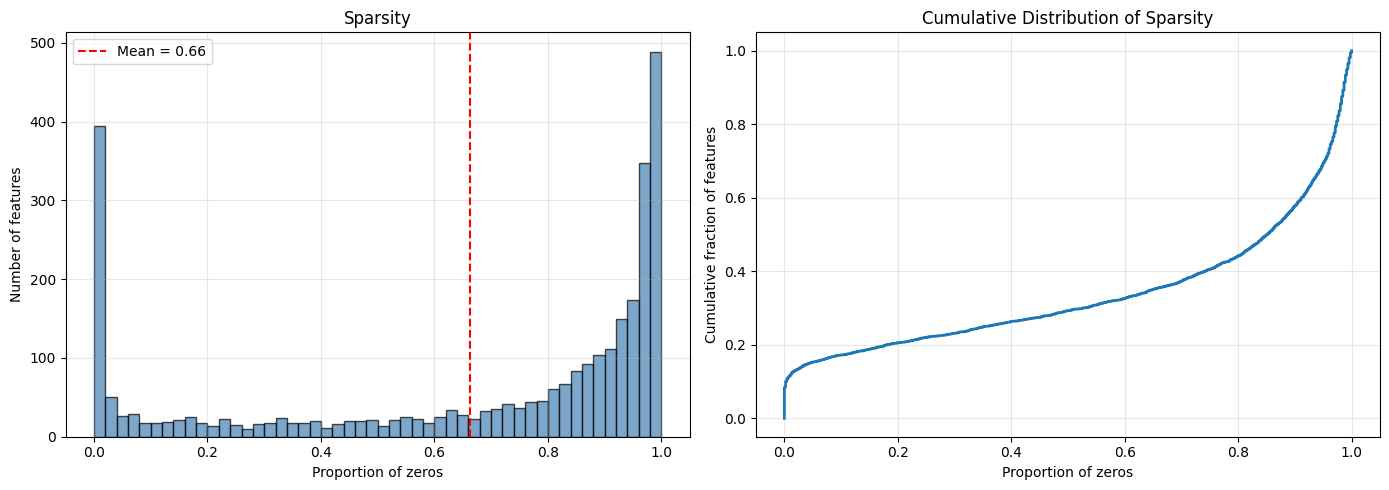

Total features: 3000
Mean proportion of zeros: 0.663
Median proportion of zeros: 0.851

features by sparsity:
  >95% zeros: 919 features (30.6%)
  >94% zeros: 1011 features (33.7%)
  >90% zeros: 1271 features (42.4%)
  All zeros:  16 features


In [7]:
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_feature, str='features')

In [8]:
# Remove genes with all zeros
genes_to_keep = proportion_zeros_feature < 0.8

print(f"Before filtering: {adata.n_vars} genes")
adata_filtered = adata[:, genes_to_keep]
print(f"After filtering: {adata_filtered.n_vars} genes")
print(f"Removed: {(~genes_to_keep).sum()} genes")

Before filtering: 3000 genes
After filtering: 1323 genes
Removed: 1677 genes


### Filtering for slide

#### Subset to cell type of interest

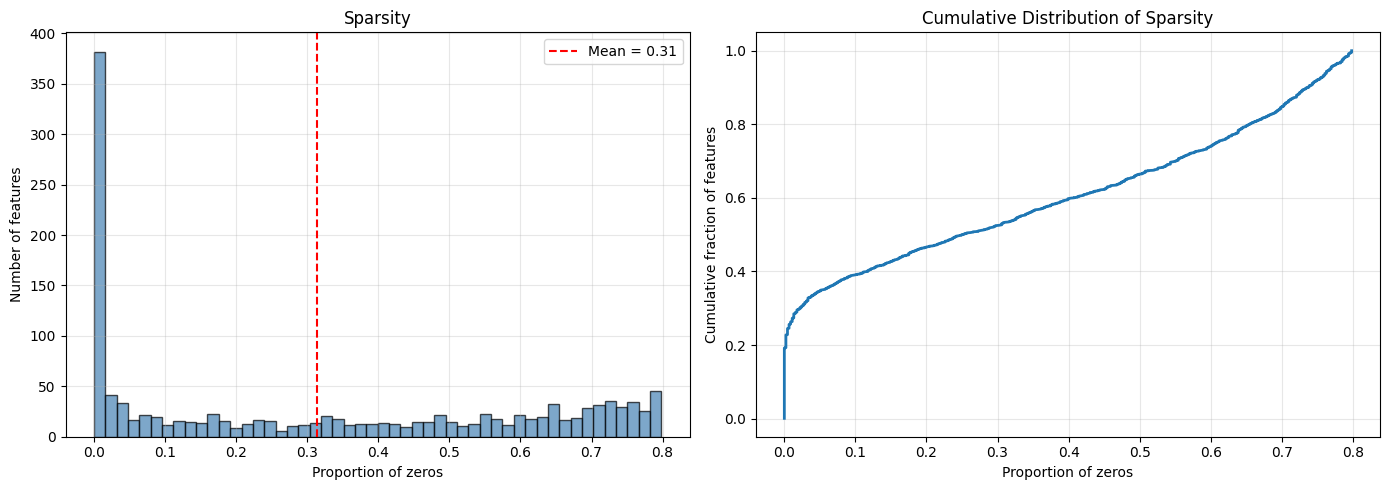

Total features: 1323
Mean proportion of zeros: 0.314
Median proportion of zeros: 0.251

features by sparsity:
  >95% zeros: 0 features (0.0%)
  >94% zeros: 0 features (0.0%)
  >90% zeros: 0 features (0.0%)
  All zeros:  0 features


In [9]:
proportion_zeros_feature = calculate_zero_proportion(adata_filtered, axis='features')
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_feature, str='features')

### Variance filtering of features

/tmp/ipykernel_35598/2609563064.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_filtered.var['variance'] = gene_variance


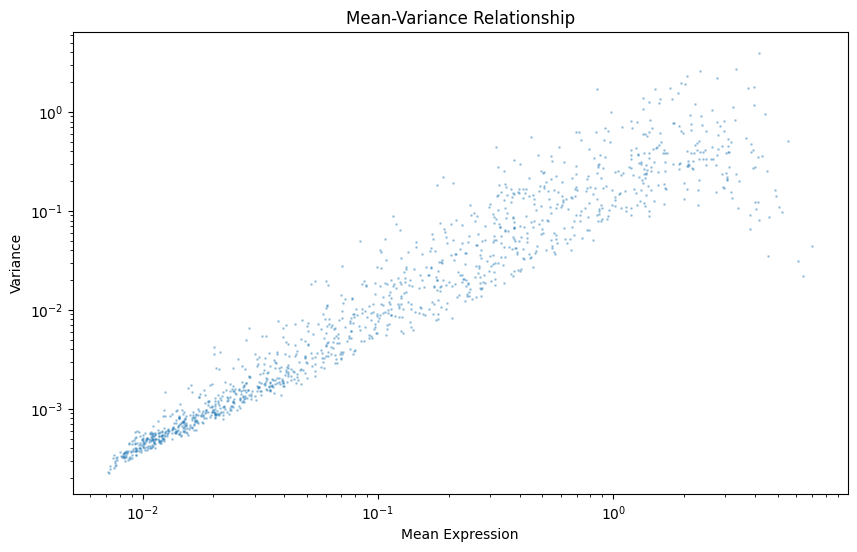

In [10]:
# Calculate mean and variance for each gene
gene_mean = np.mean(adata_filtered.X.toarray() if hasattr(adata_filtered.X, 'toarray') else adata_filtered.X, axis=0)
gene_variance = np.var(adata_filtered.X.toarray() if hasattr(adata_filtered.X, 'toarray') else adata_filtered.X, axis=0)

# Add variance to adata.var for easy access
adata_filtered.var['variance'] = gene_variance

plt.figure(figsize=(10, 6))
plt.scatter(gene_mean, gene_variance, alpha=0.3, s=1)
plt.xlabel('Mean Expression')
plt.ylabel('Variance')
plt.title('Mean-Variance Relationship')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [11]:
display(type(adata_filtered.obs))

pandas.core.frame.DataFrame

In [12]:
adata_df = pd.DataFrame(adata_filtered.X, index=adata_filtered.obs_names, columns=adata_filtered.var_names)
adata_df

,Rp1,Prex2,Sulf1,Kcnb2,Stau2,Gdap1,Gm28653,Kcnq5,Gm29506,Col19a1,...,Cdkl5,Nhs,Pir,Gpm6b,Tmsb4x,Frmpd4,Arhgap6,Gm15261,Gm15246,Mid1
SEACell,,,,,,,,,,,,,,,,,,,,,
0_F15_WT,0.000000,0.000000,0.000000,0.00000,0.777446,0.973777,0.000000,1.570912,0.000000,0.082829,...,0.096929,0.000000,0.080252,0.000000,0.000000,0.000000,3.146326,1.057538,0.000000,0.806642
0_F3_WT,0.000000,0.000000,0.000000,0.00000,1.396741,0.145456,0.000000,3.410545,0.034941,0.000000,...,0.037545,0.017754,0.166475,0.015492,0.123436,0.021430,2.692464,0.291098,0.031192,0.607631
0_F4_WT,0.000000,0.036890,0.000000,0.00000,1.793656,0.000000,0.147123,2.867817,0.181634,0.000000,...,0.138759,0.000000,0.032711,0.000000,0.120143,0.000000,2.369894,0.137891,0.032291,0.407397
0_F706_KO,0.000000,0.036313,0.000000,0.00000,1.913992,0.389875,0.000000,2.019791,0.000000,0.000000,...,0.037907,0.070573,0.241385,0.000000,0.126557,0.000000,2.909764,0.323319,0.032353,0.644393
0_F785_KO,0.000000,0.110713,0.039911,0.00000,0.811942,0.373462,0.000000,0.882997,0.038247,0.000000,...,0.032529,0.095956,0.105037,0.000000,0.273225,0.034335,2.988453,0.074189,0.000000,0.259939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_F3_WT,0.009054,0.033658,0.000000,0.00000,1.586724,0.232789,0.000000,3.686839,0.000000,0.000000,...,0.061021,0.000000,0.223010,0.034082,0.156826,0.000000,2.993458,0.130778,0.042814,0.566512
9_F4_WT,0.000000,0.000000,0.000000,0.05597,2.542080,0.000000,0.000000,3.568224,0.104155,0.000000,...,0.059024,0.000000,0.000000,0.000000,0.149010,0.000000,2.780128,0.407706,0.025453,0.809100
9_F706_KO,0.000000,0.000000,0.057798,0.00000,1.942012,0.691765,0.079784,2.866782,0.069649,0.000000,...,0.052939,0.000000,0.269412,0.042359,0.030054,0.000000,3.232216,0.448004,0.033948,0.630187


In [21]:
# Sort Y by Class
Y_sorted = adata_filtered.obs.sort_values('y', ascending=True)

# Reorder adata_df to match the same order
adata_df_sorted = adata_df.loc[Y_sorted.index]

# Verify the order is synchronized
print("Y sorted:")
display(Y_sorted)
print(f"\nKO samples (Class=1): {(Y_sorted['y'] == 1).sum()}")
print(f"WT samples (Class=0): {(Y_sorted['y'] == 0).sum()}")

print("\nX matrix sorted:")
display(adata_df_sorted)

# Verify indices match
print(f"\nIndices match: {(Y_sorted.index == adata_df_sorted.index).all()}")

Y sorted:


,y,sample_id
SEACell,,
0_F15_WT,0,F15
49_F15_WT,0,F15
48_F4_WT,0,F4
48_F3_WT,0,F3
48_F15_WT,0,F15
...,...,...
50_F7_KO,1,F7
20_F7_KO,1,F7
51_F706_KO,1,F706



KO samples (Class=1): 219
WT samples (Class=0): 232

X matrix sorted:


,Rp1,Prex2,Sulf1,Kcnb2,Stau2,Gdap1,Gm28653,Kcnq5,Gm29506,Col19a1,...,Cdkl5,Nhs,Pir,Gpm6b,Tmsb4x,Frmpd4,Arhgap6,Gm15261,Gm15246,Mid1
SEACell,,,,,,,,,,,,,,,,,,,,,
0_F15_WT,0.000000,0.000000,0.000000,0.000000,0.777446,0.973777,0.000000,1.570912,0.000000,0.082829,...,0.096929,0.000000,0.080252,0.0,0.000000,0.000000,3.146326,1.057538,0.000000,0.806642
49_F15_WT,0.000000,0.000000,0.000000,0.000000,1.798611,0.263897,0.000000,3.268850,0.019144,0.000000,...,0.089261,0.015809,0.172623,0.0,0.038141,0.000000,3.265547,1.153309,0.058187,0.629511
48_F4_WT,0.121335,0.033002,0.039803,0.000000,2.280312,0.096328,0.000000,2.835878,0.000000,0.000000,...,0.229103,0.036971,0.032220,0.0,0.025990,0.033883,2.749424,0.133937,0.098934,0.569540
48_F3_WT,0.000000,0.039306,0.000000,0.000000,1.323746,0.189117,0.000000,3.963330,0.000000,0.039617,...,0.055635,0.000000,0.000000,0.0,0.179074,0.000000,2.963474,0.267047,0.000000,0.548286
48_F15_WT,0.609407,0.000000,0.000000,0.237421,1.940650,0.046375,2.270120,3.472814,0.099947,0.000000,...,0.376016,0.000000,0.000000,0.0,0.000000,0.000000,3.013829,1.094633,0.077798,0.264468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50_F7_KO,0.052153,0.000000,0.038903,0.000000,2.169756,0.540537,0.072476,4.120295,0.075886,0.000000,...,0.392893,0.000000,0.236381,0.0,0.129269,0.000000,2.973190,0.775033,0.090720,1.138360
20_F7_KO,0.054636,0.000000,0.000000,0.022303,1.797856,0.108412,0.000000,4.019139,0.149937,0.000000,...,0.168530,0.027025,0.150809,0.0,0.028418,0.000000,2.650289,0.725238,0.000000,0.399010
51_F706_KO,0.000000,0.050502,0.105598,0.000000,2.041548,0.096478,0.022895,3.615835,0.020381,0.000000,...,0.102684,0.022030,0.224768,0.0,0.093512,0.000000,2.960459,0.106507,0.044861,0.658787



Indices match: True


In [22]:
# Update the original variables
Y = Y_sorted['y']
adata_df = adata_df_sorted

In [23]:
display(Y)

SEACell
0_F15_WT      0
49_F15_WT     0
48_F4_WT      0
48_F3_WT      0
48_F15_WT     0
             ..
50_F7_KO      1
20_F7_KO      1
51_F706_KO    1
22_F785_KO    1
9_F7_KO       1
Name: y, Length: 451, dtype: int64

In [15]:
#save to csv
out_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples"
adata_df.to_csv(os.path.join(out_dir, 'female_fast2b_2x_harmonyv2_X.csv'))

In [24]:
# save to csv
Y.to_csv(os.path.join(out_dir, 'female_fast2b_2x_harmonyv2_Y.csv'))

## Run slide

In [17]:
import loveslide
from loveslide import OptimizeSLIDE

/ocean/projects/cis240075p/asachan/.conda/envs/loveslide_dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
During startup - Warning messages:
1: package ‘methods’ was built under R version 4.4.3 
2: package ‘datasets’ was built under R version 4.4.3 
3: package ‘utils’ was built under R version 4.4.3 
4: package ‘grDevices’ was built under R version 4.4.3 
5: package ‘graphics’ was built under R version 4.4.3 
6: package ‘stats’ was built under R version 4.4.3 


In [25]:
input_params = {
    'x_path': '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_fast2b_2x_harmonyv2_X.csv',
    'y_path': '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_fast2b_2x_harmonyv2_Y.csv',
    'fdr': 0.1,
    'thresh_fdr': 0.1,
    'spec': 0.2,
    'y_factor': True,
    'niter': 500,
    'SLIDE_top_feats': 20,
    'rep_CV': 50,
    'pure_homo': True,
    'delta': [0.01],
    'lambda': [0.1, 0.05],
    'out_path': '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/female/slide_outs/pooled'
}

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package ‘tools’ was built under R version 4.4.3 




### PARAMETERS ###

x_path: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_fast2b_2x_harmonyv2_X.csv
y_path: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_fast2b_2x_harmonyv2_Y.csv
fdr: 0.1
thresh_fdr: 0.1
spec: 0.2
y_factor: True
niter: 500
SLIDE_top_feats: 20
rep_CV: 50
pure_homo: True
delta: [0.01]
lambda: [0.1, 0.05]
out_path: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/female/slide_outs/pooled
n_workers: 1
do_interacts: True

###### DATA ######

451 samples
1323 features
48.6% cases
51.4% controls

##################

Running LOVE with delta=0.01 and lambda=0.1
LOVE found 55 latent factors.

Running SLIDE knockoffs...
Calculated f_size: 55
Finding standalone LF...


Processing subsets: 100%|██████████| 1/1 [02:02<00:00, 122.76s/it]


Found 2 standalone LF
Finding interacting LF...


Processing subsets: 100%|██████████| 2/2 [04:06<00:00, 123.32s/it]


Found 2 interacting LF

SLIDE complete.

Completed 0.01_0.1

##################

Running LOVE with delta=0.01 and lambda=0.05
LOVE found 55 latent factors.

Running SLIDE knockoffs...
Calculated f_size: 55
Finding standalone LF...


Processing subsets: 100%|██████████| 1/1 [02:15<00:00, 135.23s/it]


Found 2 standalone LF
Finding interacting LF...


Processing subsets: 100%|██████████| 2/2 [04:14<00:00, 127.20s/it]


Found 2 interacting LF

SLIDE complete.

Completed 0.01_0.05

##################



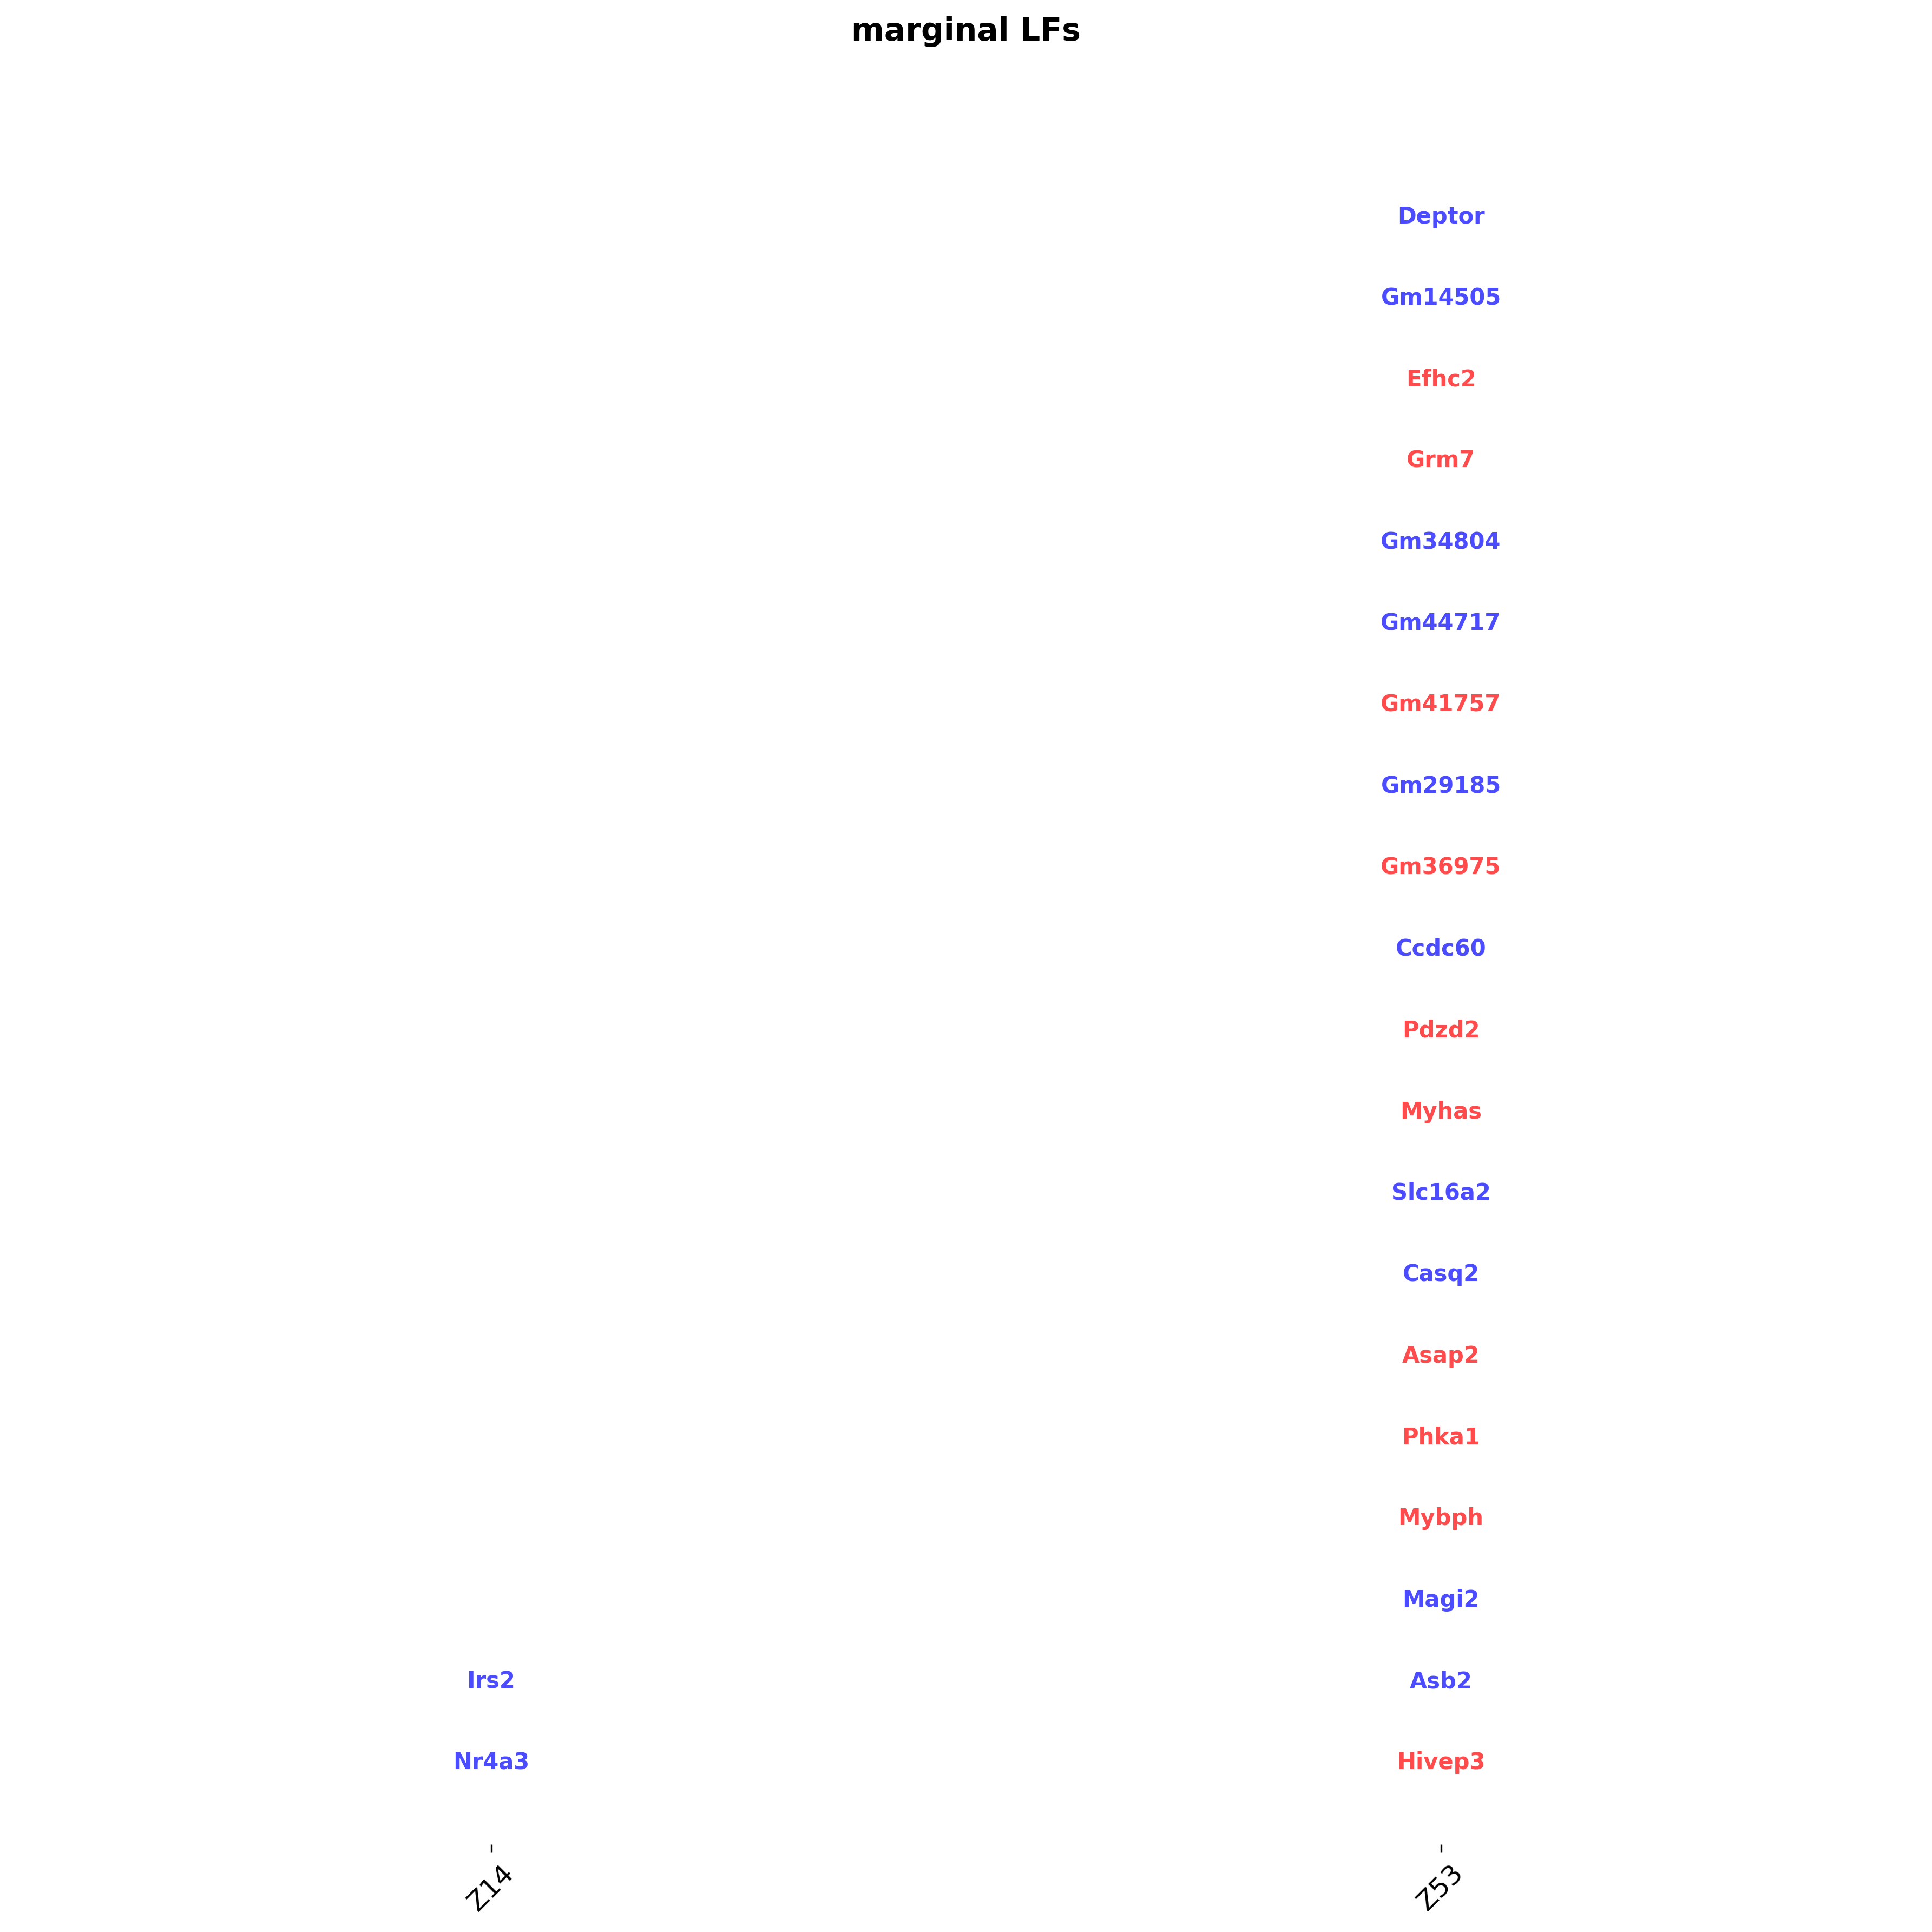

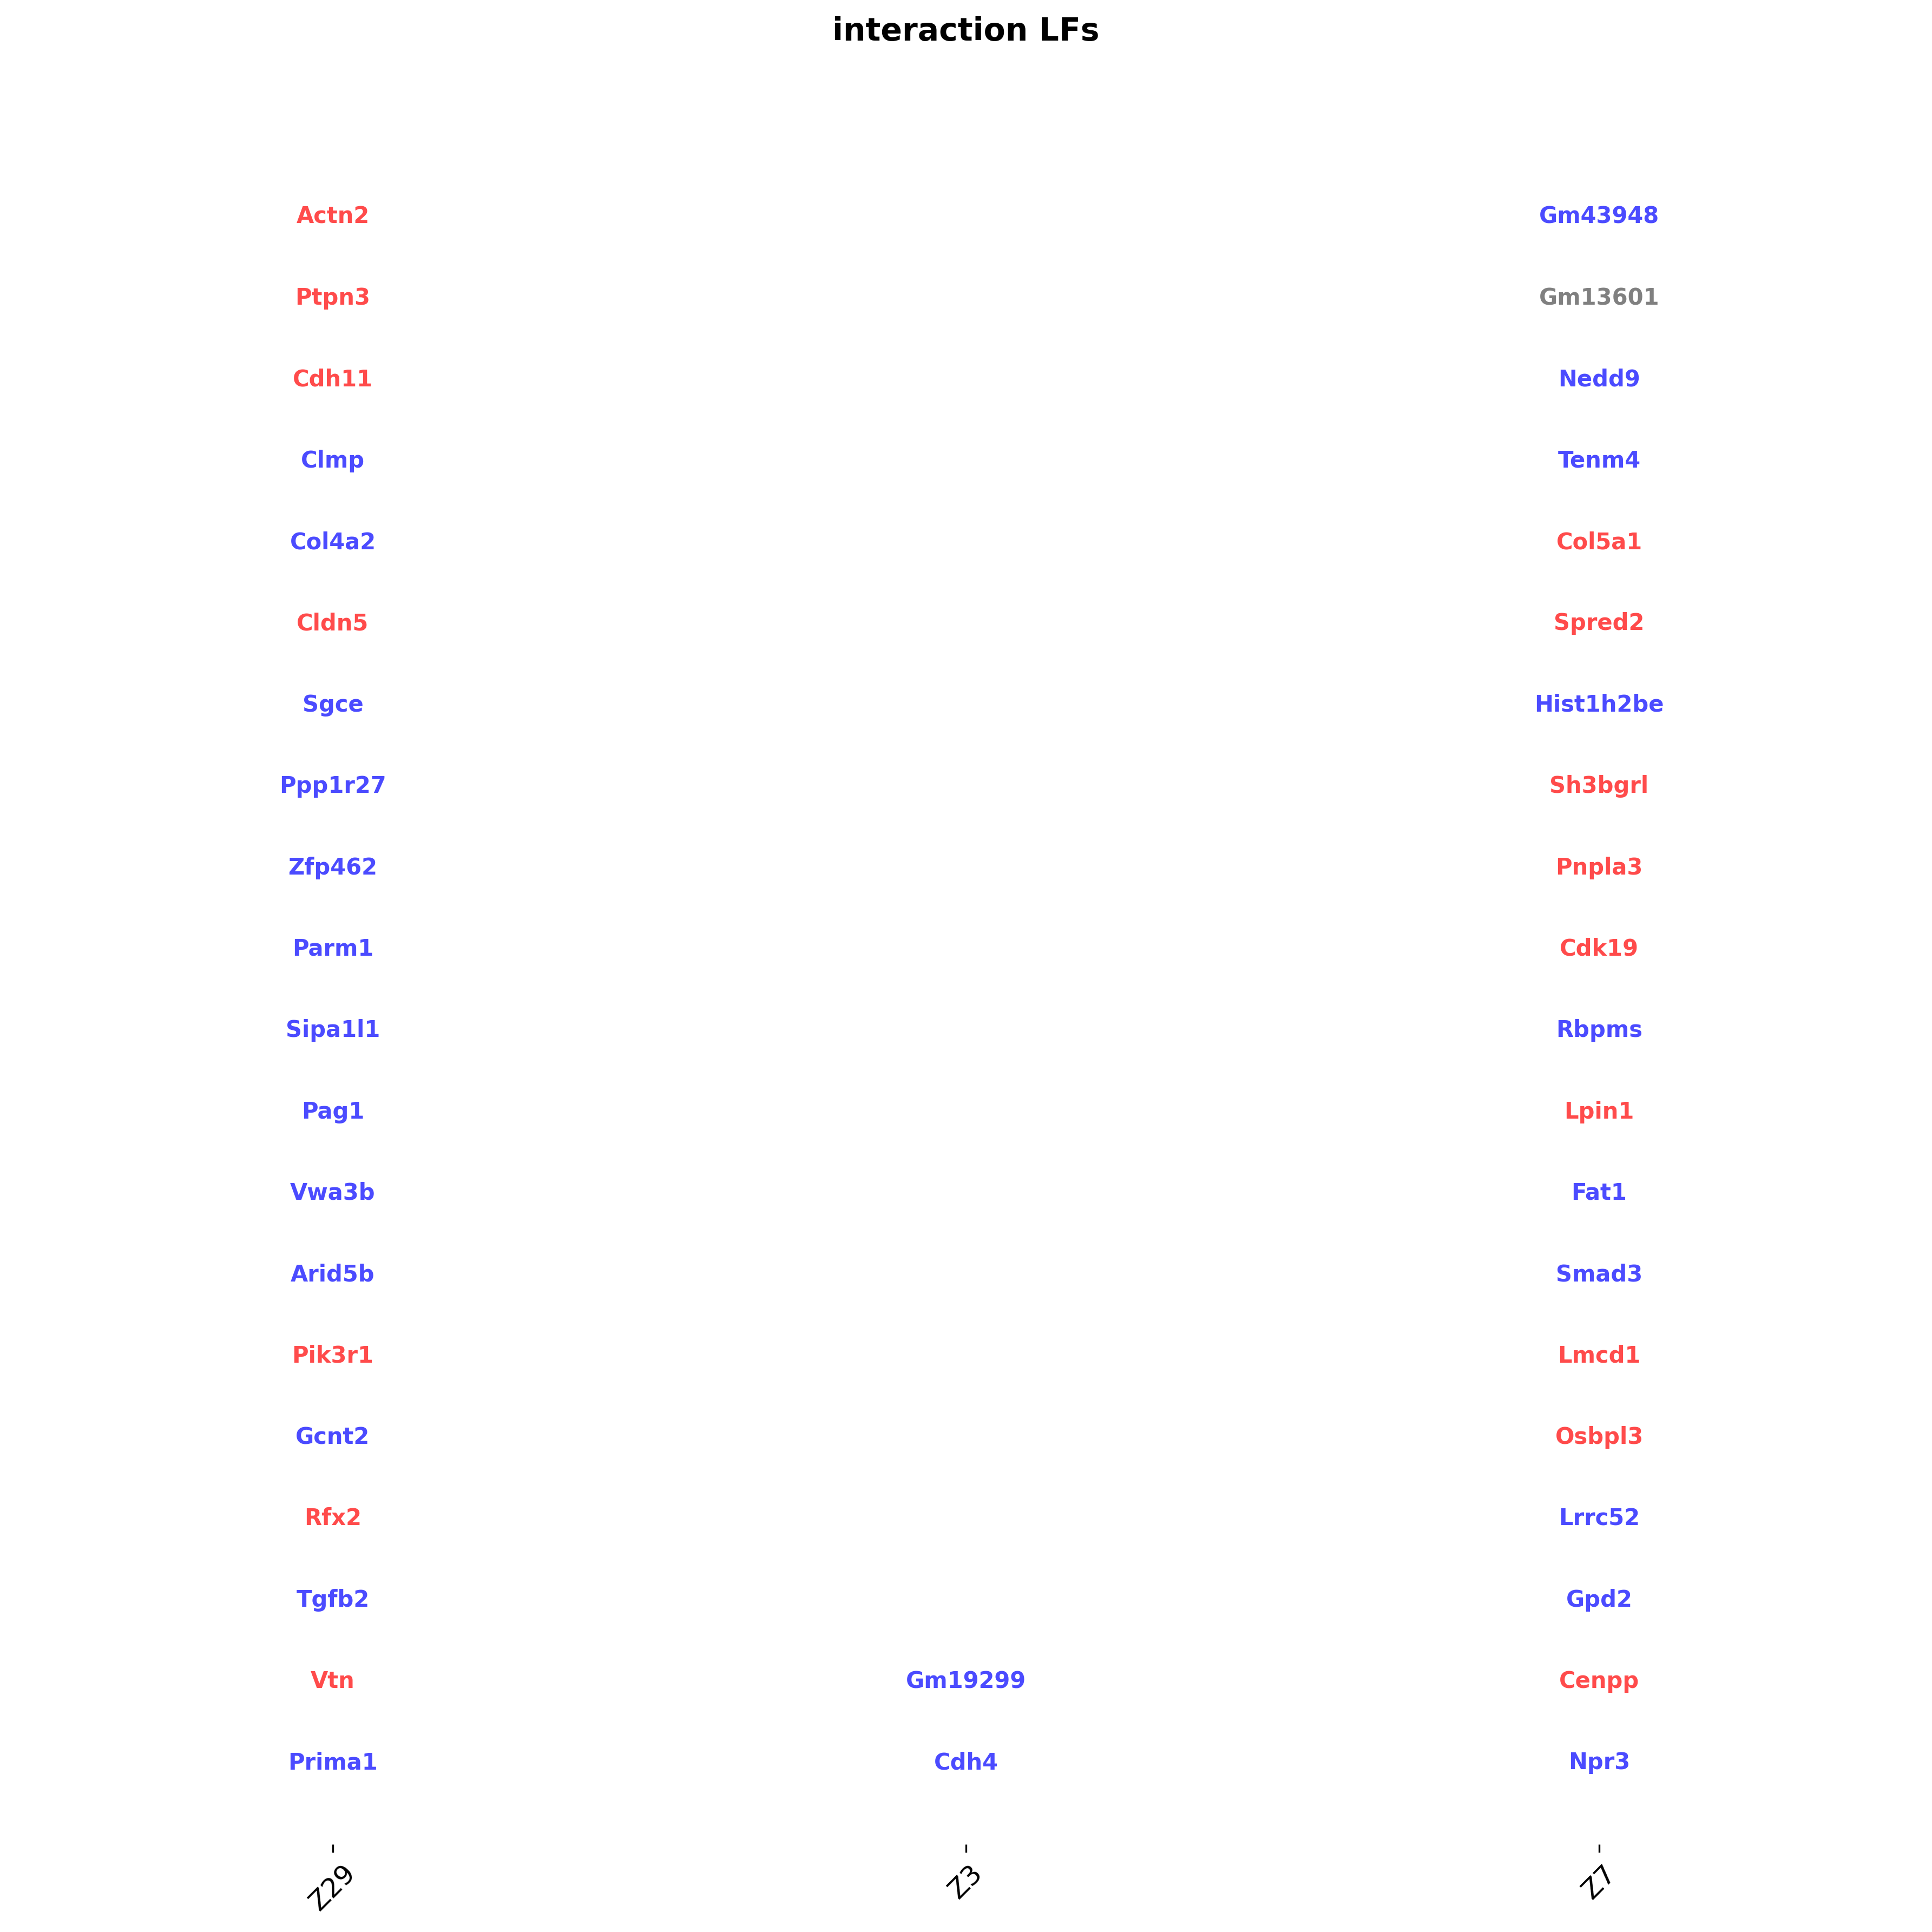

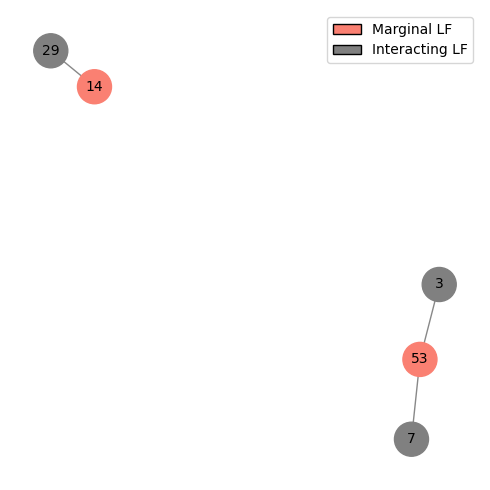

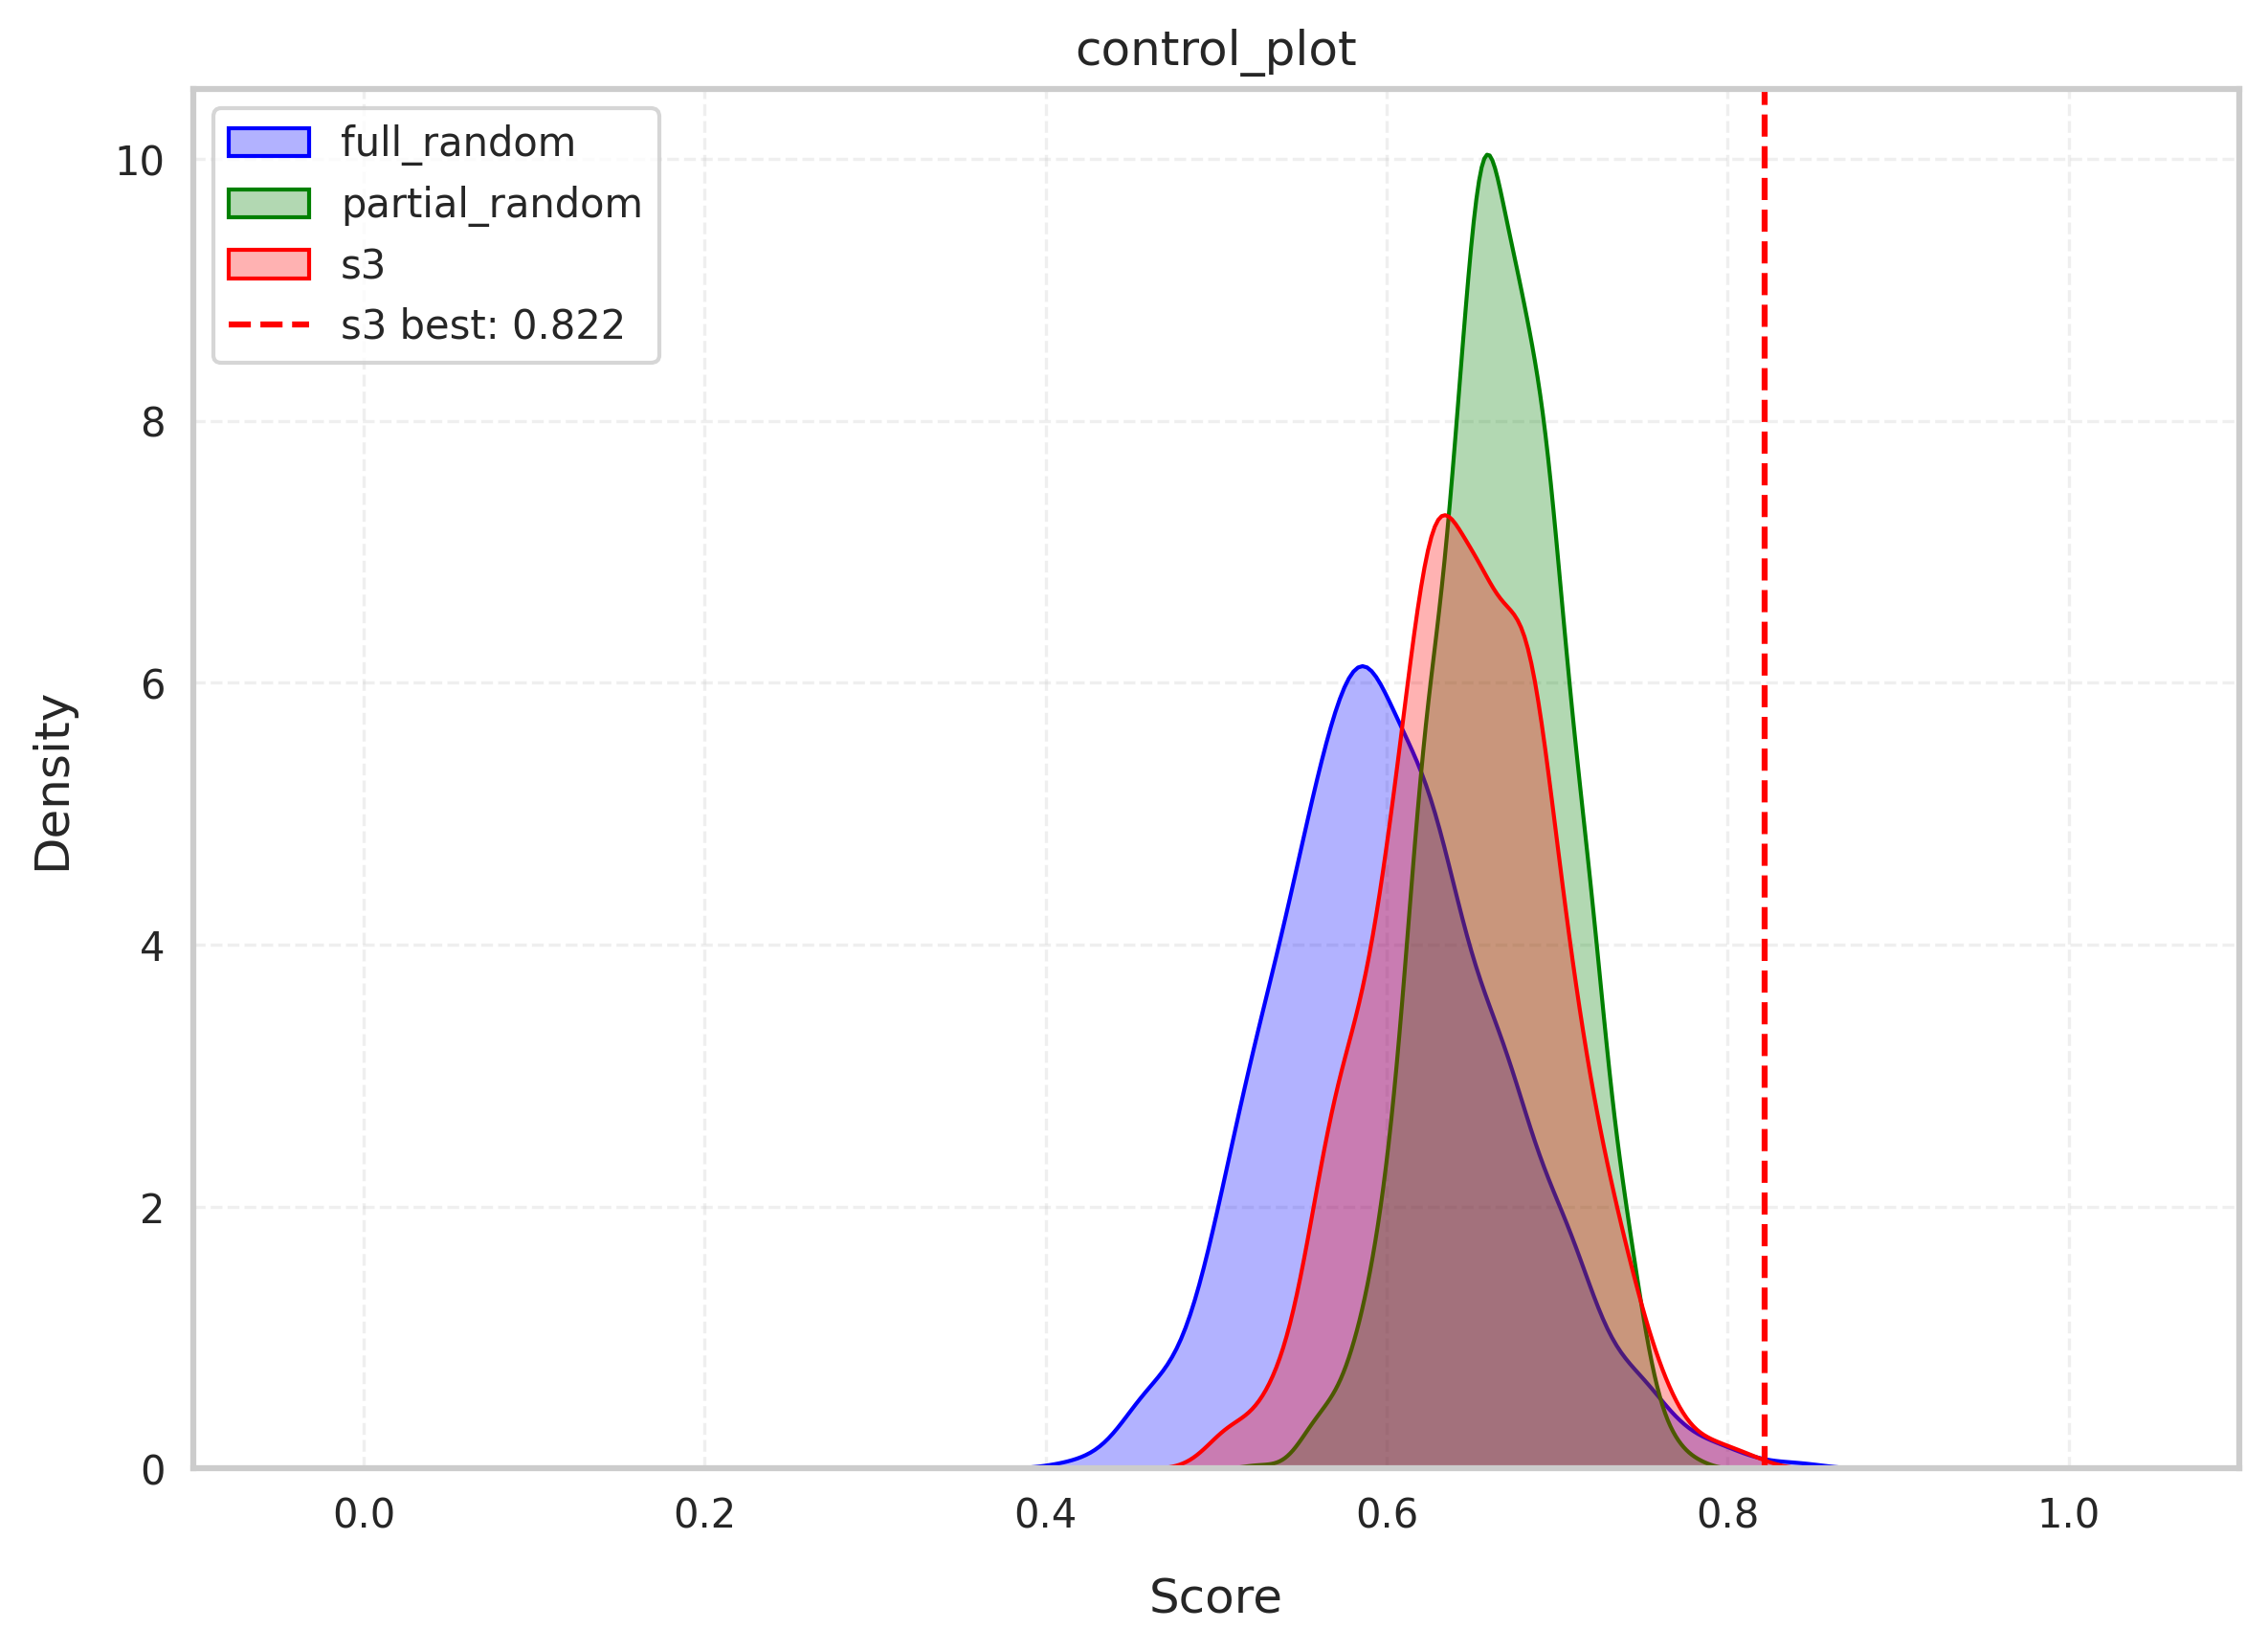

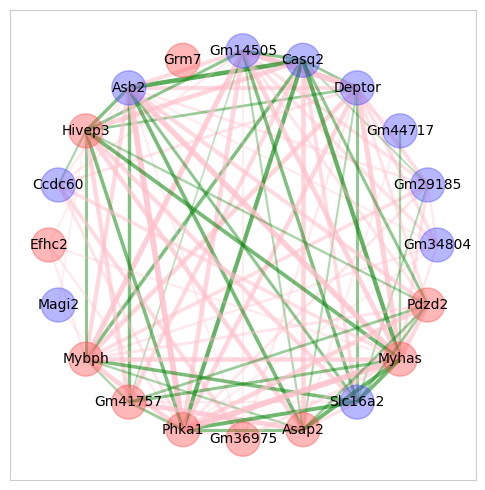

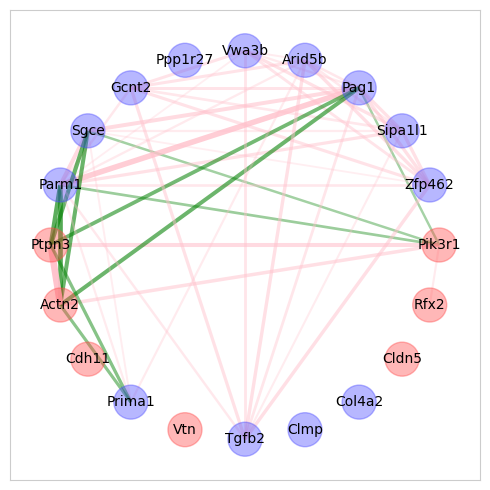

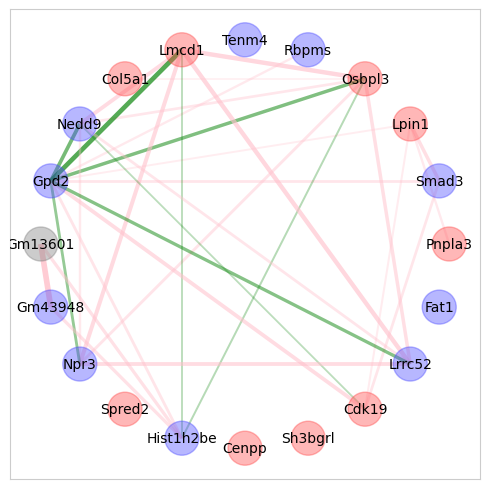

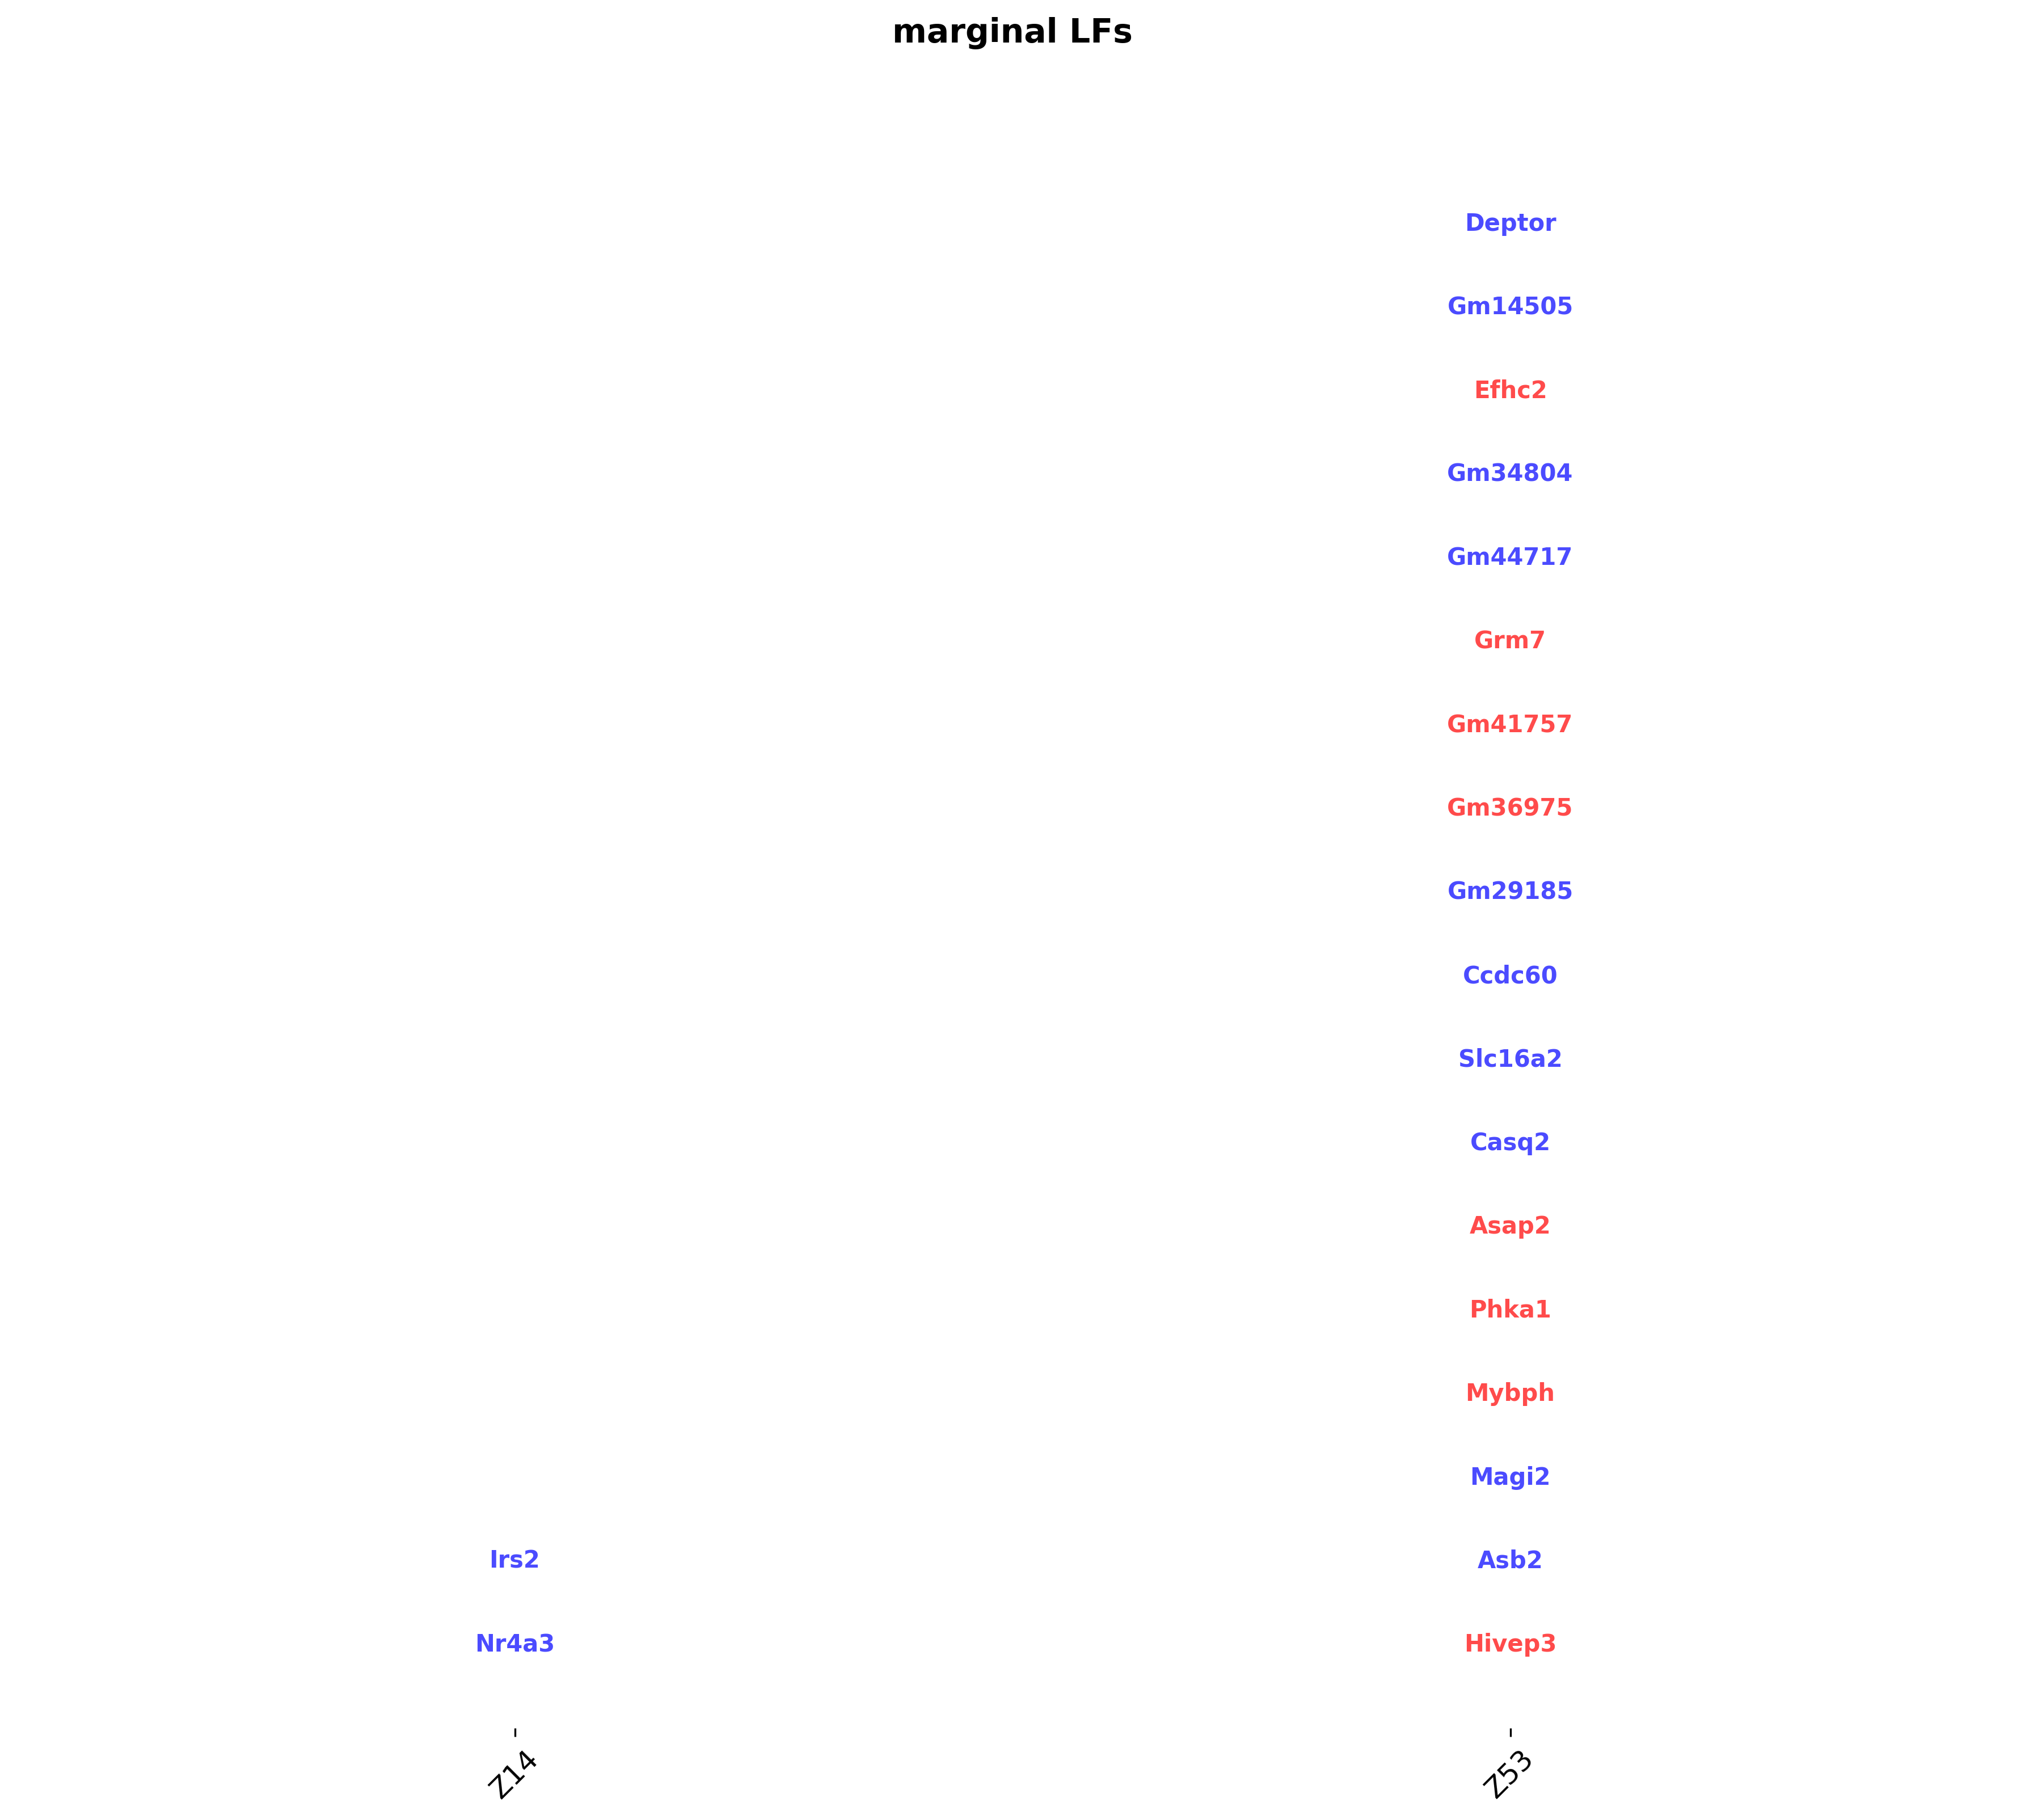

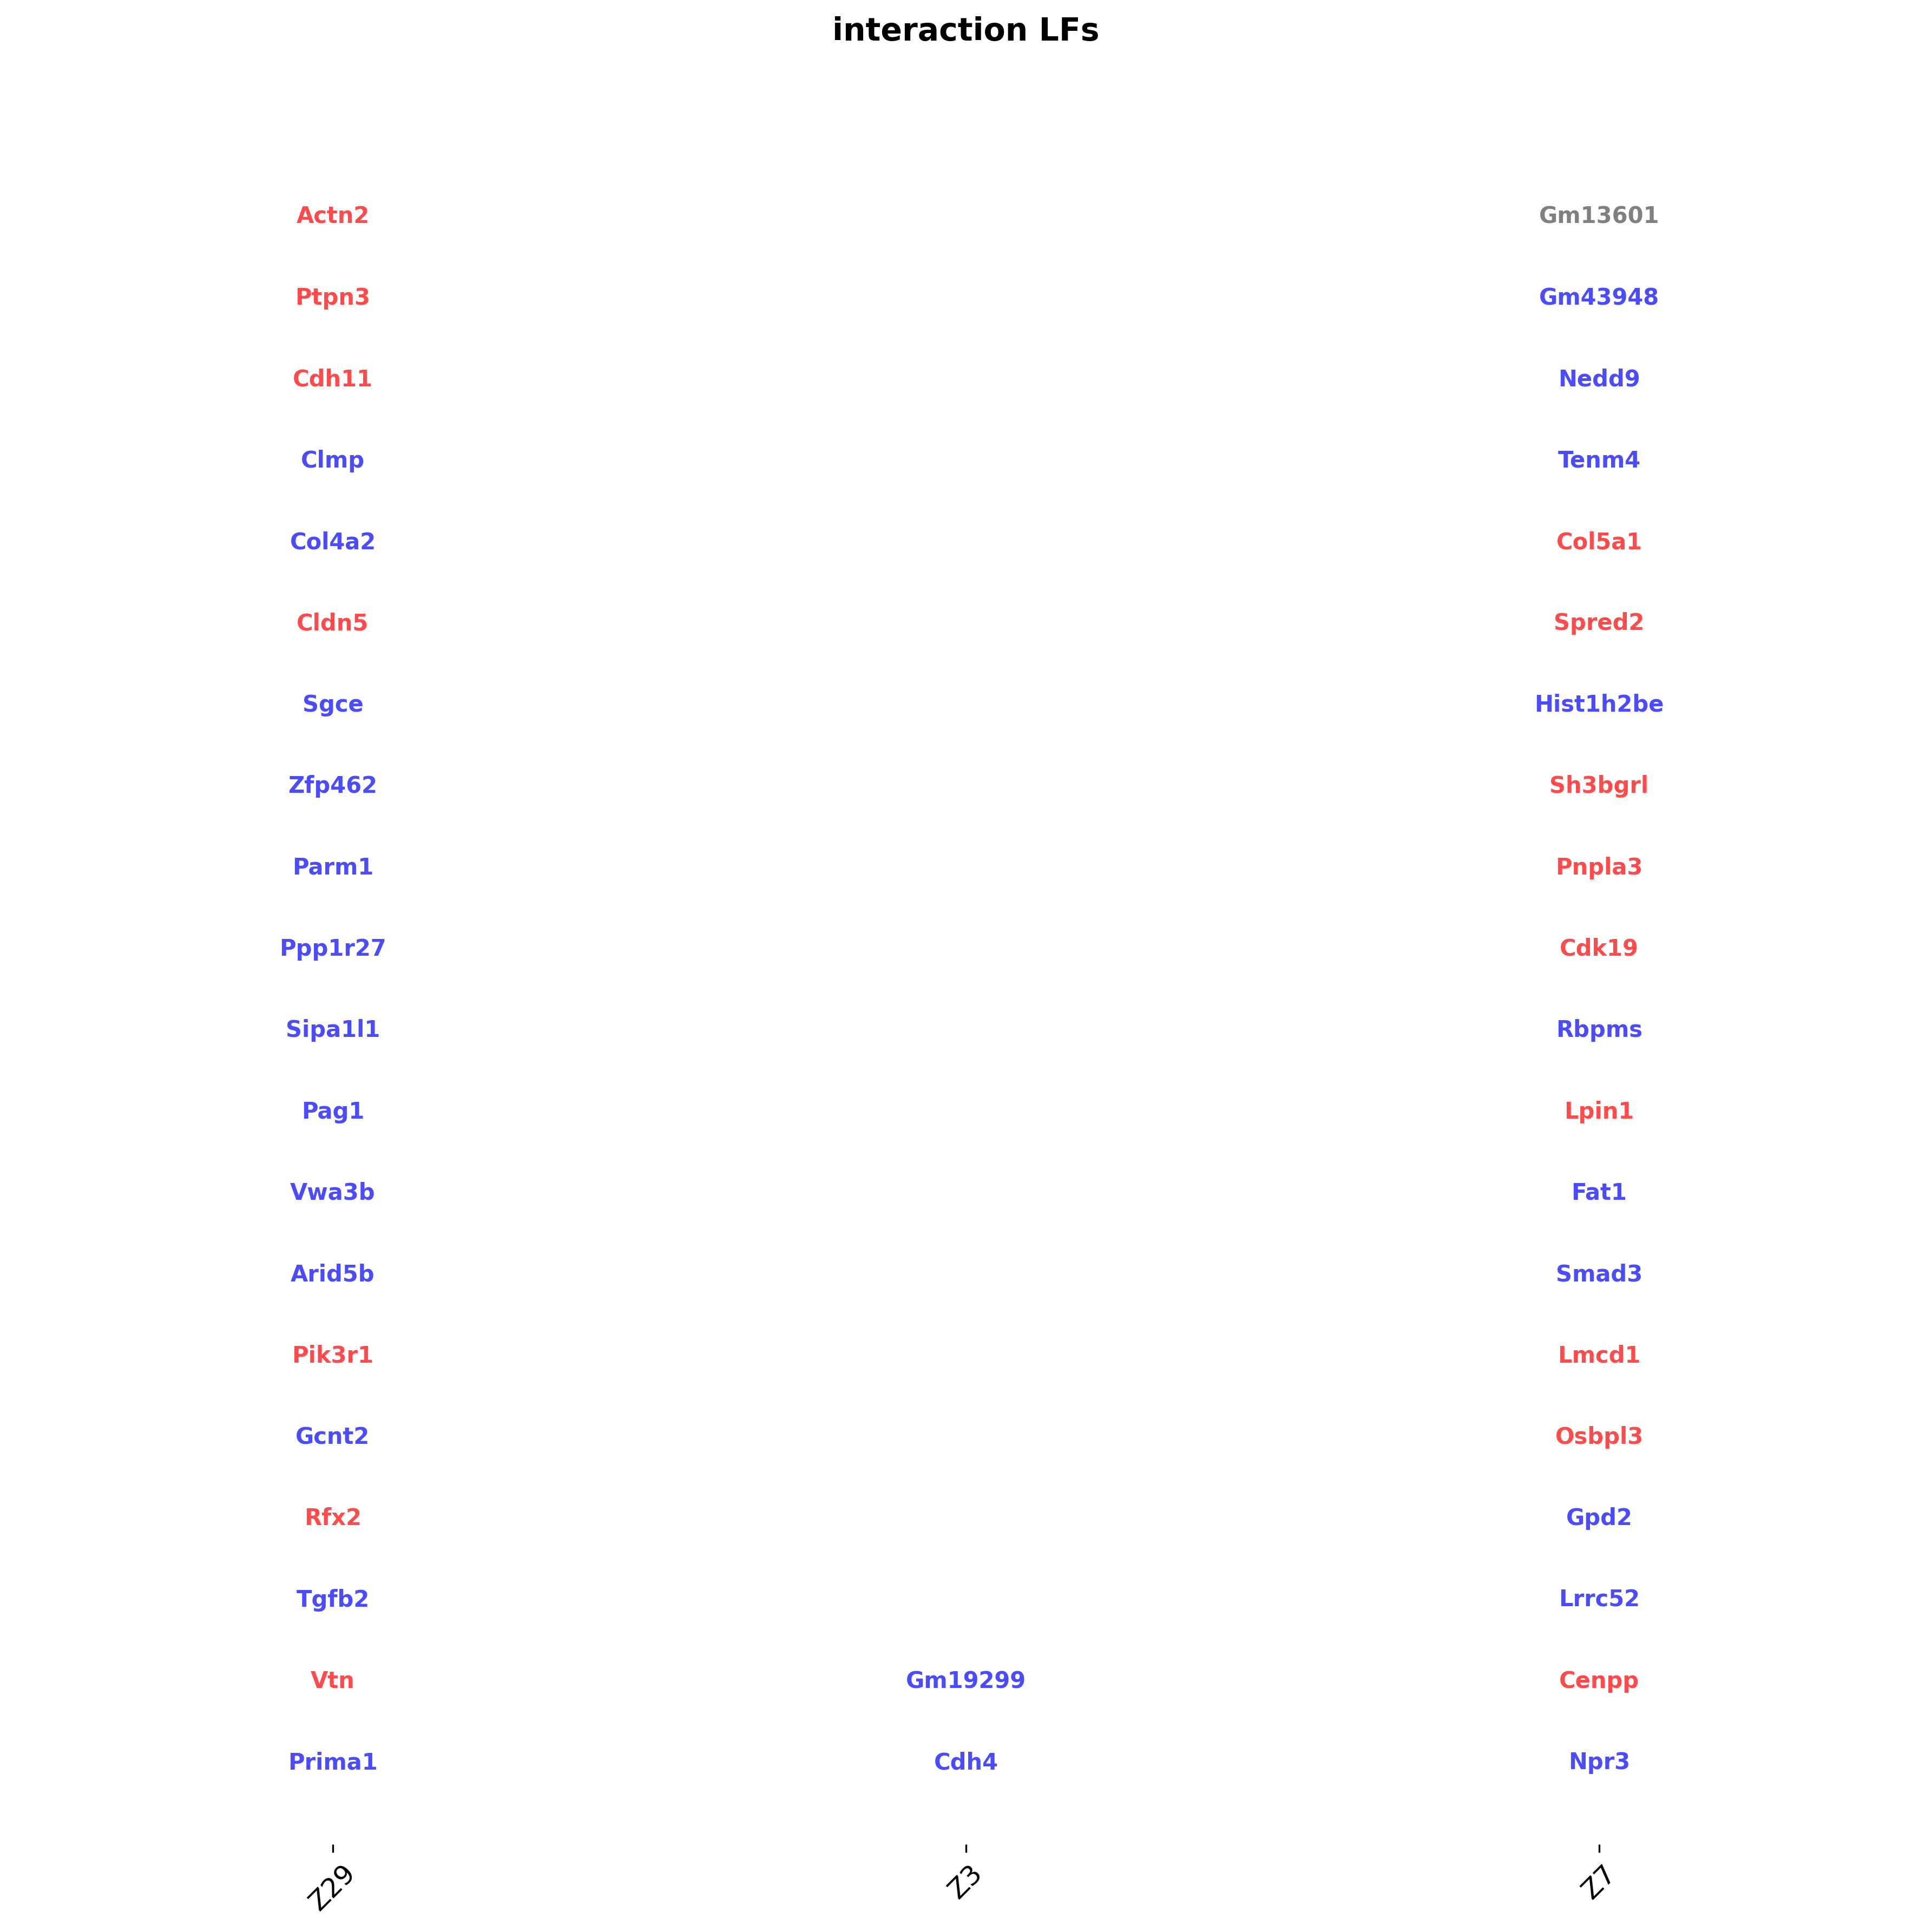

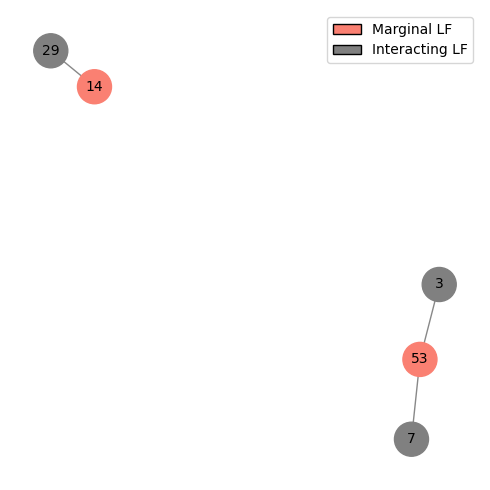

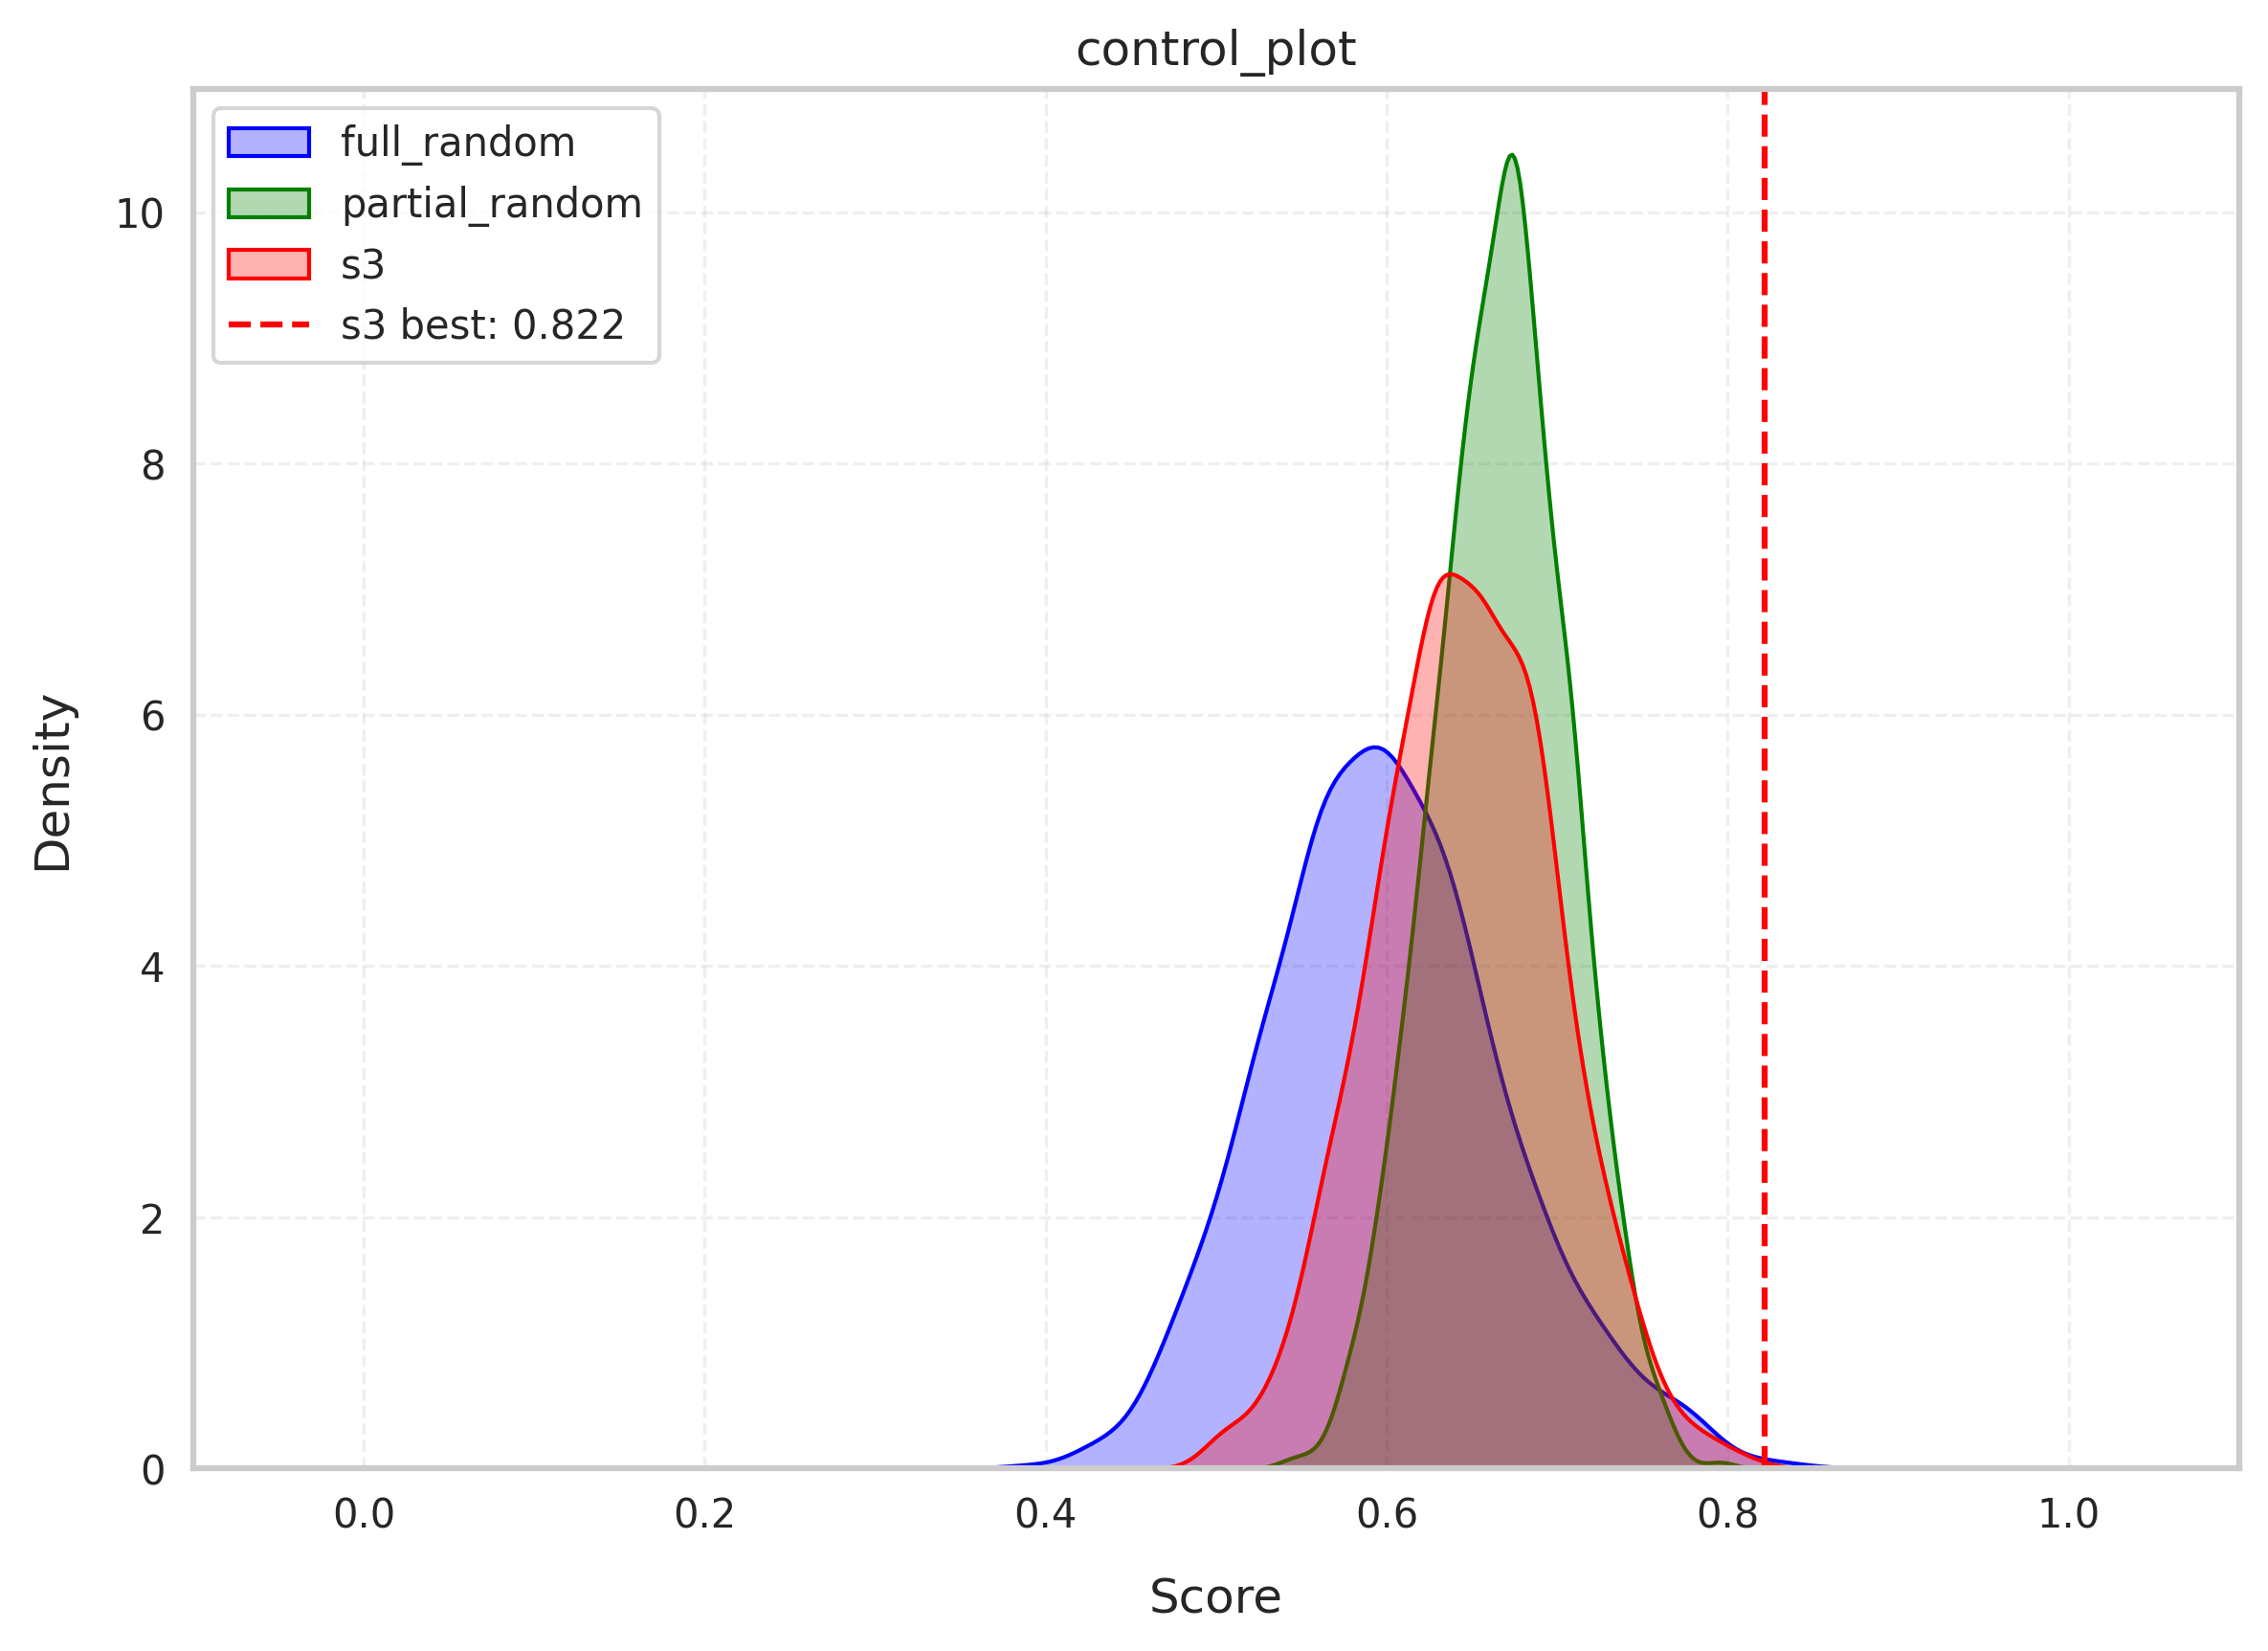

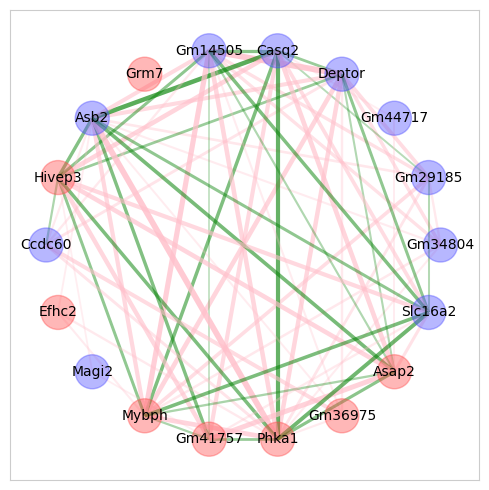

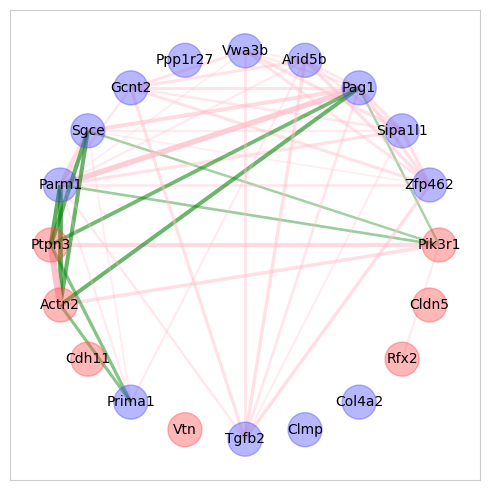

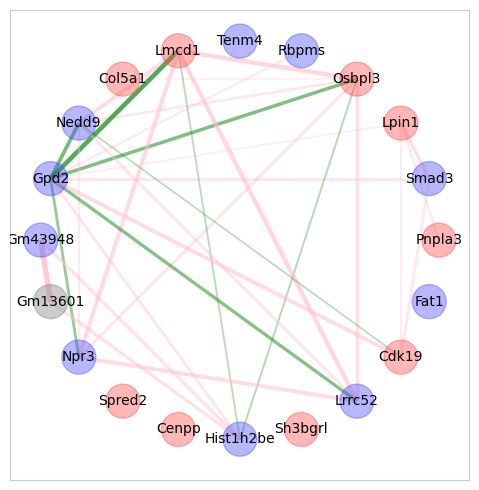

In [26]:
slider = OptimizeSLIDE(input_params)
slider.run_pipeline(verbose=True, n_workers=1)